In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.transforms import Rescale, RandomCrop
from src.models.joint_face_det_model import JointDetectionModule
from src.data.Dataset import LS3DDataset
from src.models.loss import JointLoss
from src.models.metrics import map_eval, get_bbox
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.dataloader import DataLoader
import albumentations as albu
import albumentations.pytorch.transforms
import torch
import cv2
from tqdm import tqdm
from loguru import logger


In [5]:
BATCH_SIZE = 1
LEARNING_RATE = 10 ** (-4)
LR_FACTOR = 10
EPOCHS = 50
CHECKPOINT_PATH = '../models/joint_det_models/model_train.pth.tar'
LOG_PATH = '../log/train_notebook.log'

In [6]:
def load_model(model_name):
    path = f'../models/joint_det_models/{model_name}.pth.tar'

    model = JointDetectionModule()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    try:
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        logger.info(f'Model loaded. Curent loss:{loss}, epoch:{epoch}')
        return True, model, loss, epoch, optimizer, scheduler
    except FileNotFoundError:
        logger.info(f'No saved model')
        return False, model, float('inf'), 0, optimizer, scheduler

In [7]:
from PIL import Image
from matplotlib import pyplot as plt, patches
import numpy as np
%matplotlib inline

def draw_image_with_landmarks_bbox(image, landmarks, bbox):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    ax.scatter(landmarks[:, 0], landmarks[:, 1], s=8, c='g')
    if bbox[0] < 1:
        print('kek')
        rect = patches.Rectangle(((bbox[0]-bbox[2]/2)*288, (bbox[1]-bbox[3]/2)*288), bbox[2]*288, bbox[3]*288, linewidth=1, edgecolor='r', facecolor='none') 

    else:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()
    
def draw_image_with_landmarks(image, landmarks):
    landmarks = np.array(landmarks)
    fig, ax = plt.subplots(1)
    print(image.shape)
    ax.imshow(image)
    ax.scatter(landmarks[:, 0], landmarks[:, 1], s=8, c='g')
    plt.show()

def draw_image_with_bbox(image, bbox):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    if bbox[0] < 1:
        print('kek')
        rect = patches.Rectangle(((bbox[0]-bbox[2]/2)*288, (bbox[1]-bbox[3]/2)*288), bbox[2]*288, bbox[3]*288, linewidth=1, edgecolor='r', facecolor='none') 
    else:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [8]:
dataset = LS3DDataset(csv_file='../data/train.csv',
                          root_dir='../data/LS3D-W',
                          transformations=[Rescale(288)],
                          albu_transformations=[albu.PadIfNeeded(288, 288, border_mode=cv2.BORDER_CONSTANT, value=[0,0,0]),
                                               
                                                albu.pytorch.transforms.ToTensor()])
dataloader = DataLoader(dataset, batch_size=1,
                            shuffle=True, num_workers=0)

b, model, _, _, _, _ = load_model('model_val_fix')

model.eval()
device = torch.device("cpu")

criterion = JointLoss(device)
for i, batch in enumerate(dataloader):
    
    with torch.no_grad():
        image = batch['image']
        landmarks_target = batch['landmarks_2d']
        bbox_target=batch['bbox']
        pred = model(image)
        nme, loc_loss, conf_loss, box_pred = criterion(pred, (bbox_target, landmarks_target))   
        box_pred, landmarks_pred = box_pred[0],box_pred[1].view(-1, 68,2)
        
        break
   
    

RuntimeError: Attempting to deserialize object on CUDA device 1 but torch.cuda.device_count() is 1. Please use torch.load with map_location to map your storages to an existing device.

In [9]:
i = torch.argmax(box_pred[:,4])
draw_image_with_landmarks(image[0].permute(1,2,0), landmarks_pred[i])

draw_image_with_bbox(image[0].permute(1,2,0), box_pred[i])

print(box_pred[i])
box_pred[i]=torch.tensor([0,0,0,0,0])


NameError: name 'box_pred' is not defined

tensor([0., 0., 0., 0., 0.])
tensor(104)


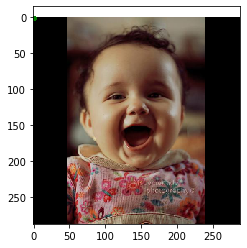

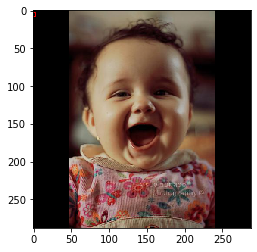

tensor([ 1.8730,  1.8730, -6.3767,  6.3767,  0.5205])


In [43]:
print(box_pred[i])
i = torch.argmax(box_pred[:,4])
print(i)
draw_image_with_landmarks(image[0].permute(1,2,0), landmarks_pred[i])
draw_image_with_bbox(image[0].permute(1,2,0), box_pred[i])

print(box_pred[i])

kek


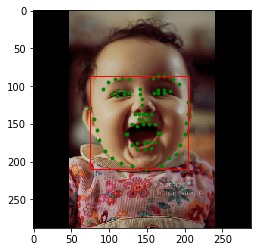

tensor([[[0.4840, 0.5140, 0.4505, 0.4240]]])

In [12]:
draw_image_with_landmarks_bbox(image[0].permute(1,2,0), landmarks_target[0][0], bbox_target[0][0])
bbox_target

In [13]:
batch['image'].size()

torch.Size([1, 3, 288, 288])

In [14]:
bbox_target[0][0]*288

tensor([139.3874, 148.0320, 129.7297, 122.1120])

In [15]:
bbox_target[0][0]

tensor([0.4840, 0.5140, 0.4505, 0.4240])

In [16]:
gt_x = bbox_target[0, 0, 0]
gt_y = bbox_target[0, 0, 1]
gt_w = bbox_target[0, 0, 2]
gt_h = bbox_target[0, 0, 3]

In [17]:
 gt_i = int(gt_x * 9)
gt_j = int(gt_y * 9)

In [18]:
gt_i

4

In [19]:
gt_j

4

In [20]:
288/9 *3

96.0

In [21]:
288/9 *5

160.0

In [22]:
0.4167*288

120.0096

In [23]:
0.5929*288

170.7552

In [24]:
288/9

32.0

In [25]:
int(30/288*9)

0

In [26]:
32/288

0.1111111111111111

In [27]:
1.5/9 *288

48.0

In [28]:
torch.expm1(bbox_target)

tensor([[[0.6225, 0.6720, 0.5690, 0.5281]]])

In [29]:
torch.log1p(torch.tensor([[[0.5169, 0.8092, 0.2261, 0.2088]]]))

tensor([[[0.4167, 0.5929, 0.2038, 0.1896]]])

In [30]:
bbox_target


tensor([[[0.4840, 0.5140, 0.4505, 0.4240]]])